<a href="https://colab.research.google.com/github/dongjun-kor/Python/blob/main/%ED%97%88%EA%B9%85%ED%8E%98%EC%9D%B4%EC%8A%A4_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BERT를 활용하여 CPC섹션 분류하기

##데이터 불러오기 및 전처리

huggingface 패키지를 Colab에 설치합니다

In [2]:
!pip install transformers==3.3.0
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 880 kB 86.7 MB/s 
     |████████████████████████████████| 1.2 MB 74.4 MB/s 
     |████████████████████████████████| 3.0 MB 67.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=829ed86cd25f6b344822182d9f90e61a1590f26e586b0b526b6300b23bb505d5
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import re

In [4]:
from transformers import AutoModelForMaskedLM

구글 드라이브와 Colab을 연동합니다.  


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


GDrive와 코랩을 연동합니다.  
Gdrive 상의 Colab Notebooks/청와대 폴더에 Dacon에서 다운받은 train.csv와 test.csv를 업로드 해 줍니다.  
path에 경로를 지정해주도록 하겠습니다.

In [7]:
path = "gdrive/My Drive/Colab Notebooks/청와대"

In [22]:
#os.listdir("gdrive/My Drive/Colab Notebooks/청와대")

train 데이터와 test 데이터를 pandas dataframe 형식으로 불러오도록 하겠습니다.

In [25]:
train = pd.read_csv("/content/gdrive/MyDrive/train1.csv",encoding="cp949")
test = pd.read_csv("/content/gdrive/MyDrive/test.csv",encoding="cp949")
#submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [24]:
train.head(5)

,ID,cat,info,도트,content,번역,상태,대응 IPC,메인그룹비교
0,A01B-0001/00,A,0,0.0,Hand tools (edge trimmers for lawns A01G3/06; ...,수(手)작업구 (잔디 끝 부분을 베어내는 기구 A01G3/06; 토(土)작업을 위한...,NaN,A01B1/00,동일
1,A01B-0001/02,A,0,1.0,Spades; Shovels (hand-operated dredgers E02F3...,가래; 삽 수동 굴착기 E02F3/02,NaN,A01B1/02,동일
2,A01B-0001/022,A,0,2.0,Collapsible; extensible; combinations with ot...,접이식; 신축자재식; 다른 도구와의 조합,NaN,A01B1/02,동일
3,A01B-0001/024,A,0,2.0,Foot protectors attached to the blade,칼날에 부착된 발 보호구,NaN,A01B1/02,동일
4,A01B-0001/026,A,0,2.0,with auxiliary handles for facilitating lifting,승강을 용이하게 하기 위한 보조 손잡이를 가지는 것,NaN,A01B1/02,동일


In [25]:
test.head(5)

,ID,cat,info,도트,content,번역,상태,대응 IPC,메인그룹비교
0,H01H-2229/03,H,7,2.0,Laminating,라미네이팅,NaN,CPCONLY,상이
1,H01H-2229/032,H,7,2.0,Screw,나사,NaN,CPCONLY,상이
2,H01H-2229/034,H,7,1.0,Positioning of layers,층의 위치결정,NaN,CPCONLY,상이
3,H01H-2229/036,H,7,1.0,ultrasonic,초음파,NaN,CPCONLY,상이
4,H01H-2229/038,H,7,1.0,Folding of flexible printed circuit,가요 인쇄회로의 접힘,NaN,CPCONLY,상이


train 데이터와 test 데이터를 전처리하도록 하겠습니다.  
특수 문자들을 제거하고, 띄어쓰기가 많은 부분만 간단히 전처리 해주도록 하겠습니다.

In [26]:
train['content'] = train['content'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\\n\t]+', " ", regex=True)
test['content'] = test['content'].str.replace(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', " ", regex=True)
train['content'] = train['content'].str.replace(r'\t+', " ", regex=True)
test['content'] = test['content'].str.replace(r'\t+', " ", regex=True)
train['content'] = train['content'].str.replace(r'[\\n]+'," ", regex=True)
test['content'] = test['content'].str.replace(r'[\\n]+'," ", regex=True)

전처리가 어느정도 된 것을 확인하실 수 있겠습니다.

In [27]:
train.head(5)

,ID,cat,info,도트,content,번역,상태,대응 IPC,메인그룹비교
0,A01B-0001/00,A,0,0.0,Ha d tools edge trimmers for law s A01G3 06; ...,수(手)작업구 (잔디 끝 부분을 베어내는 기구 A01G3/06; 토(土)작업을 위한...,NaN,A01B1/00,동일
1,A01B-0001/02,A,0,1.0,Spades; Shovels ha d operated dredgers E02F3...,가래; 삽 수동 굴착기 E02F3/02,NaN,A01B1/02,동일
2,A01B-0001/022,A,0,2.0,Collapsible; exte sible; combi atio s with ot...,접이식; 신축자재식; 다른 도구와의 조합,NaN,A01B1/02,동일
3,A01B-0001/024,A,0,2.0,Foot protectors attached to the blade,칼날에 부착된 발 보호구,NaN,A01B1/02,동일
4,A01B-0001/026,A,0,2.0,with auxiliary ha dles for facilitati g lifti g,승강을 용이하게 하기 위한 보조 손잡이를 가지는 것,NaN,A01B1/02,동일


In [28]:
test.head(5)

,ID,cat,info,도트,content,번역,상태,대응 IPC,메인그룹비교
0,H01H-2229/03,H,7,2.0,Lami ati g,라미네이팅,NaN,CPCONLY,상이
1,H01H-2229/032,H,7,2.0,Screw,나사,NaN,CPCONLY,상이
2,H01H-2229/034,H,7,1.0,Positio i g of layers,층의 위치결정,NaN,CPCONLY,상이
3,H01H-2229/036,H,7,1.0,ultraso ic,초음파,NaN,CPCONLY,상이
4,H01H-2229/038,H,7,1.0,Foldi g of flexible pri ted circuit,가요 인쇄회로의 접힘,NaN,CPCONLY,상이


## 버트 인풋 만들기

huggingface에 쓸 모델과 토크나이저를 불러옵니다.  
그저 실행만 해주시면 됩니다.  
한글 버트 등 좋은 모델이 많지만, 편의상 구글의 <b> multilingual bert </b>를 활용하도록 하겠습니다.
(특허의 상세설명은 영문이므로, base_uncased)

토크나이저를 불러옵니다. bert를 활용하도록 하겠습니다.

In [27]:
tokenizer = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

train 데이터를 버트 인풋에 맞게 변경해줍니다.  
즉, 문장을 버트 인풋에 맞게 토큰, 마스크, 세그먼트로 변환해 주겠습니다.

In [29]:
def convert_data(data_df):
    global tokenizer
    
    SEQ_LEN = 512 #SEQ_LEN : 버트에 들어갈 인풋의 길이
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df)), position=0, leave=True):
        # token : 문장을 토큰화함
        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, truncation = True, padding='max_length')
       
        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        # 정답(긍정 : 1 부정 0)등 을 targets 변수에 저장해 줌
        targets.append(data_df[LABEL_COLUMN][i])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

SEQ_LEN = 512
BATCH_SIZE = 20
# 긍부정 문장을 포함하고 있는 칼럼
DATA_COLUMN = "content"
# 긍정인지 부정인지를 (1=긍정,0=부정) 포함하고 있는 칼럼
LABEL_COLUMN = "info"

# train 데이터를 버트 인풋에 맞게 변환
train_x, train_y = load_data(train)

100%|██████████| 208206/208206 [01:28<00:00, 2355.50it/s]


## 버트를 활용한 민원분류 모델 만들기

버트 훈련을 빠르게 하기 위해, TPU를 사용하도록 하겠습니다.  
TPU 사용을 원치 않으시면 TPU 관련된 부분은 실행하시지 않으면 되겠습니다.

In [30]:
# TPU 객체 만들기
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.35.135.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.135.218:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


감정 분석에 맞는 버트 모형을 리턴하는 함수를 정의하도록 하겠습니다.  
TPU를 활용하려면 함수로 묶어야 합니다.

In [10]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [32]:
model = TFBertModel.from_pretrained("bert-base-uncased", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already

In [31]:
def create_sentiment_bert():
  # 버트 pretrained 모델 로드
  model = TFBertModel.from_pretrained("bert-base-uncased", from_pt=True)
  # 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
  token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
  mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
  segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
  # 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
  bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

  bert_outputs = bert_outputs[1]
  sentiment_first = tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02))(bert_outputs)
  sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)
  # 옵티마이저는 간단하게 Adam 옵티마이저 활용
  sentiment_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['sparse_categorical_accuracy'])
  return sentiment_model

## 훈련 및 성능 검증

In [48]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)
# TPU를 활용하기 위해 context로 묶어주기
with strategy.scope():
  
  sentiment_model = create_sentiment_bert()
  sentiment_model.fit(train_x, train_y, epochs=3, shuffle=False, batch_size=20)
      

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized f

Epoch 1/3


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 512) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int64>]


10411/10411 [==============================] - 1499s 136ms/step - loss: 0.0322 - sparse_categorical_accuracy: 0.9943
Epoch 2/3
10411/10411 [==============================] - 1366s 131ms/step - loss: 0.0238 - sparse_categorical_accuracy: 0.9958
Epoch 3/3
10411/10411 [==============================] - 1364s 131ms/step - loss: 0.0269 - sparse_categorical_accuracy: 0.9955


In [50]:
sentiment_model.save_weights(os.path.join("/content/gdrive/MyDrive","sentiment_model.h5"))

In [11]:
from keras.models import load_model

In [33]:
sentiment_model = create_sentiment_bert()
sentiment_model.load_weights("/content/gdrive/MyDrive/sentiment_model.h5")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already

In [34]:
from IPython.display import SVG

In [35]:
from tensorflow.keras.utils import model_to_dot

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already

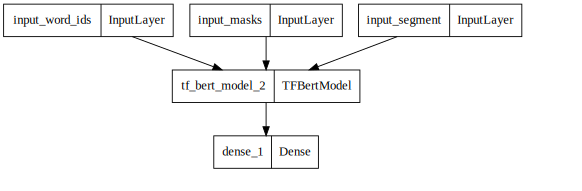

In [36]:
SVG(model_to_dot(create_sentiment_bert(), dpi = 65).create(prog='dot', format='svg'))

In [37]:
from sklearn.metrics import classification_report

In [38]:
from keras import Input, Model

In [48]:
def get_feature_map(sentiment_model):
  inputs = sentiment_model.input
  outputs =sentiment_model.layers[-2].output
  feature_model = Model(inputs, outputs)
  return feature_model

In [49]:
bert_feature = get_feature_map(sentiment_model)

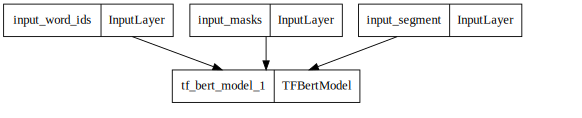

In [50]:
SVG(model_to_dot(bert_feature, dpi = 65).create(prog='dot', format='svg'))

In [36]:
# 만약 TPU 사용을 원치 않는다면
#sentiment_model = create_sentiment_bert()
#sentiment_model.fit(train_x, train_y, epochs=3, shuffle=False, batch_size=10)
#sentiment_model.save_weights(os.path.join(path,"sentiment_model.h5"))

우리가 훈련한 버트 모델을 적용하기 위해, Test 데이터를 버트 인풋에 맞게 변환하겠습니다.

In [102]:
def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []
    
    for i in tqdm(range(len(data_df))):

        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, truncation=True, padding='max_length')
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        segments.append(segment)
        masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]
SEQ_LEN = 512
DATA_COLUMN = 'content'
# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def predict_load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x

In [52]:
test1=test[:-52000]

In [ ]:
test1

In [103]:
test_set = predict_load_data(test1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 55/55 [00:00<00:00, 3758.28it/s]


In [105]:
bert_weight_list = bert_feature.predict(test_set)

In [123]:
bert_weight_list2=bert_weight_list[1]

In [56]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [124]:
bert_embedded = TSNE(n_components=2).fit_transform(bert_weight_list2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [125]:
bert_embedded

array([[-3.1168268e+01,  7.7300239e+00],
       [ 3.6521755e+01, -3.1185728e+01],
       [ 2.8576939e+01,  1.8896967e+01],
       [-5.6644341e+01, -2.3564238e+01],
       [ 1.7075495e+01,  2.7875242e+00],
       [-4.3158733e+01, -2.3294426e+01],
       [ 5.7858349e+01,  6.7052655e+00],
       [ 3.8170570e+01,  9.6012325e+00],
       [ 6.5781631e+01, -3.3313665e+00],
       [-1.9297953e+01,  1.7789953e+01],
       [ 2.8351301e+01, -6.7292438e+00],
       [ 4.7469555e+01,  3.9397056e+00],
       [ 7.8357110e+00,  2.4789040e+00],
       [ 5.5518689e+00, -3.3830578e+01],
       [-2.6670807e+01, -1.8822030e+00],
       [ 6.5425659e+01, -1.4426508e+01],
       [-4.2471882e+01,  6.6411271e+00],
       [-3.9094834e+00,  3.9289385e-02],
       [ 4.5902576e+01,  1.6444555e+01],
       [-4.7310081e+01, -2.7686727e+00],
       [-1.5435453e+01, -1.1321805e+00],
       [-2.1029385e+01,  7.3578315e+00],
       [-3.7289520e+01, -2.0750225e+00],
       [-6.8444000e+01, -2.6265582e-01],
       [ 5.32267

In [89]:
bert_embedded = PCA(n_components=256).fit_transform(bert_weight_list)
bert_embedded = TSNE(n_components=2).fit_transform(bert_embedded)
bert_embedded

ValueError: ignored

In [66]:
g=pd.DataFrame(bert_embedded)
g.to_csv("/content/gdrive/MyDrive","bert_embedded.csv")

NameError: ignored

test 데이터를 BERT 모형을 활용해서 카테고리(0:인권/성평등, 1:문화/예술/체육/언론, 2: 육아/교육)를 예측한 후 Dacon에 파일을 제출해 보도록 하겠습니다.  
먼저 "sample_submission.csv"라는 제출 파일을 로드하도록 하겠습니다.

In [39]:
submission = pd.read_csv(os.path.join(path,"sample_submission.csv"))

FileNotFoundError: ignored

In [ ]:
import shutil
if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree(path, "bert")

In [ ]:
import sys
mod = sys.modules[__name__]
strategy = tf.distribute.experimental.TPUStrategy(resolver)
# TPU를 활용하기 위해 context로 묶어주기
with strategy.scope():
  sentiment_model = create_sentiment_bert()
  
  sentiment_model.load_weights(os.path.join("bert", "sentiment_model.h5"))
  setattr(mod, 'model', sentiment_model)
  setattr(mod, 'pred_', sentiment_model.predict(test_set, batch_size=1))

In [ ]:
# 만약 TPU를 사용하지 않는다면
#sentiment_model = create_sentiment_bert()
  
#sentiment_model.load_weights(os.path.join("bert", "sentiment_model.h5"))
#setattr(mod, 'model', sentiment_model)
#setattr(mod, 'pred_', sentiment_model.predict(test_set, batch_size=1))

버트 모형에서 예측 결과를 평균해주는 함수를 정의합니다.

In [ ]:
def mean_answer_label(*preds):
  preds_sum = np.zeros(preds[0].shape[0])
  for pred in preds:
    preds_sum += np.argmax(pred, axis=-1)
  return np.round(preds_sum/len(preds), 0).astype(int)

In [ ]:
submission['category'] = mean_answer_label(pred_)

최종 Dacon에 제출할 파일을 csv파일로 만듭니다.

In [ ]:
submission.to_csv(os.path.join(path, "제출.csv"), index=False)

구글 드라이브에서 파일 바로 다운 받기

In [ ]:
from google.colab import files
files.download(os.path.join(path, "제출.csv"))

제출 결과는 테스트 데이터에 대해서 88.28%가 나왔습니다.  
다양한 방법으로 점수를 높여보시기 바랍니다.
![대체 텍스트](https://i.imgur.com/L8s4Cy8.png)

# 실제 데이터 넣어보기

국민 청원의 글을 실제로 입력하고, 아웃풋이 어떻게 나오는지 확인하도록 하겠습니다.

In [ ]:
mod = sys.modules[__name__]




def sentence_convert_data(data):
    global tokenizer
    
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN, padding='max_length', truncation=True)
    
    num_zeros = token.count(0) 
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros 
    segment = [0]*SEQ_LEN

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def category_evaluation_predict(sentence):
    cat_dict = {'0':"인권/성평등", '1':"문화/예술/체육/언론", '2': "육아/교육"}
    global mod
    sentence = re.sub("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…]+", "", sentence)
    sentence = re.sub("\\n+", " ", sentence)
    sentence = re.sub("\\t+", " ", sentence)
    data_x = sentence_convert_data(sentence)
    
    global strategy
    with strategy.scope():
      
      setattr(mod, 'chung', model.predict(data_x, batch_size=1))

    

    preds = str(mean_answer_label(chung).item())
    

    if preds == '0':
      print(cat_dict[preds]," 카테고리 입니다.")
    elif preds == '1':
      print(cat_dict[preds]," 카테고리 입니다.")
    elif preds == '2':
      print(cat_dict[preds]," 카테고리 입니다.")

In [ ]:
chungwon = """안녕하세요 저는 **동 **아파트 2동에 거주한지 이제 2년째 되가는 입주민입니다. 주택에서만 쭉 살다가 물 좋고 공기좋은 이 곳에 와서 행복한 나날을 보내던 중 어제 정말 허망하고 억울한 소식을 들었습니다.
저희 아파트 경비아저씨가 주차문제로 인해 4월말부터 20일정도 말로 설명할 수 없이 힘든 폭언으로 인해 생을 마감하셨다는 소식이였습니다...
정말 좋으신 분이셨습니다. 처음 이사와서 저한테 아니 입주민들에게 매번 잘해주시고 자기 가족인것처럼 자기일인것처럼 매번 아파트 주민분들을 위해 희생하시는 성실한 분이셨습니다.. 같이 깨끗하게 살아야한다면서 아파트 안쪽 청소도 모자라 아파트 밖까지 청소하시는 정말 열심히 사시는 분이셨습니다.. 아침마다 먼저 오셔서 안녕하세유라며 먼저 인사해주시는 힘든 출근길에 웃음을 주시는 비타민같은 존재셨습니다. 그래서 처음 아파트에 살아보면서 불편하다고 생각이 하나도 안들정도로 잘해주셨고 대학생 딸분이야기 하시면서 저도 딸같이 생각이 드셨는지 공주님이라고 칭해주시면서 엄청 챙겨주시고 예뻐해주시고 귀여워해주시던 아저씨 생각하니 눈물이 앞을 가립니다.. 처음에는 공주님이라는 칭호가 부담스러워서 좀 이상하신분인가 오해했던 제가 너무 죄송하네요.. 그만큼 엄청 좋으신 분이셨단겁니다..
근데 주차장이 협소합니다 두 동밖에 없어서인지 많이 협소하긴 합니다.. 주차를 하기위해 주말이면 여러번 뱅뱅 돌아야하는 고충이 있습니다. 그 주차문제때문에 일이 벌어졌더군요... 이중주차로 인해서 자기차를 밀었다고 사람을 죽여버리겠다고 협박을 하고 근무시간마다 와서 때리고 욕하고 씨씨티비만 봐도 인성이 딱 보이는 그런 ... 나쁜사람에게 그 순진하시고 연약한 분이 매번 폭언으로 얼마나 힘드셨을까요... 생각만 해도 가슴이 찢어집니다.. 그런데 그 가해자분은 그런 분에게 사죄하는 마음도 일도없이 언론인터뷰에서 아무것도 모른단식입니다. 오히려 명예훼손으로 맞고소를 했다고.. 정말 인간인가 싶습니다.
우리 애들 10명 풀어서 땅에 묻어줄까라는 말을 하는거보면 조폭 관련된 분이실 것 같은데요, 연예계 종사하시는 분 매니져일 하시던 분이라고 들었는데 조폭관련일 하는 사람이면 수사진행부탁드립니다. 기사 댓글만 봐도 강북하면 조폭 알아준단 식인데 강북구 조폭들 수사 강하게 원합니다. 그래야 이렇게 강자가 약자를 협박하고 폭행하는 일이 없을 것 같습니다. 마음같아서는 사형 집행해달라고 말씀드리고싶은데.. 철철히 다 수사해서 경비아저씨의 억울함을 풀어드리고 싶습니다. 사형은 아니더라도 무기징역 원합니다. 그리고 경비아저씨들이나 하청 용역분들 보호해주세요.. 경비아저씨들도 한 가정의 사랑받는 소중한 할아버지 남편 아빠입니다. 입주민의 갑질.. 없어져야 합니다. 오히려 아파트를 위해 입주민들을 위해 고생하신다고 응원을 해드려야합니다..
정말 좋으신 분이셨습니다.. 그 노고를 알아서 아저씨가 힘드신일 당하신거 알고 입주민들이 산재도 알아봐주시고 이번일 벌어지고나서도 입주민들이 그 분 쫒아내고 신고하려고 희의도 진행했다고도 들었고, 아저씨가 너무 무서워하시고 스트레스 받아하시니까 병원에도 입원시켜드렸다고 들었습니다.. 그만큼 열심히 사셨고 정말 순수하시고 좋은분이신겁니다. 저만해도 문창과 나왔어도 글도 잘 못쓰고 챙피한 마음이지만 아저씨가 그만큼 저한테 잘해주시고 열심히 해 주셨기에 안타깝고 화가나는 마음에 처음 국민청원을 올려봅니다.
제발 아저씨의 억울함을 풀어주세요
엄한 형벌이 나올수있게 같이 힘써주세요.
문재인 대통령님 부디 약자가 강자에게 협박과 폭행을 당해서 자살을 하는 경우가 없는 나라가 되게 해주십시오̤̫..
긴 글 읽어주셔서 감사합니다"""

In [ ]:
category_evaluation_predict(chungwon)

In [ ]:
chungwon = """29일 오전 0시 1분쯤 대전 동구의 한 네거리에서 훔친 렌터카를 몰던 10대 청소년 8명이 경찰 검문에 걸리자 뒤에 있던 택시를 들이받고 중앙선을 넘어 도주하면서 경찰과의 추격전 중 사망사고를 낸 청소년들을 엄중처벌 바랍니다. 사망자는 올해 대학에 입학하여 생활비를 벌기위해 배달대행 일을 하다가 사망하였습니다. 당시 렌트카 운전자는 만 14세 미만 형사 미성년자로 촉법소년에 해당해 형사처분 대신 보호처분을 받을 것이라고 경찰이 소명하였습니다. 이는 사람을 죽인 끔찍한 청소년들의 범죄입니다. 피해자와 그의 가족, 또 앞으로 이런 일이 일어나지 않게 가해자 청소년들을 꼭 엄중히 처벌바랍니다."""
category_evaluation_predict(chungwon)

In [ ]:
chungwon = """지금 우리나라뿐 아니라 모든 나라가 코로나19사태로 어려움을 겪고 있습니다.

우리나라는 중국과의 지정학적 위치 때문에 코로나 19의 어려움을 조기에 겪었으나 정부와 국민들의 적극적인 참여로
폐쇄없이 정상적인 상황에서 코로나19사태를 진정 시키고 있습니다.

이에 세계 각국에서 우리나라를 코로나19 극복 모범사례로 인식하고 ~ 최근에는 트럼프대통령도 우리나라에 진단키트
제공을 협조 했습니다.

이에 수출하는 진단키트 제품명을 "독도"로 해주시기를 청원 드리는 바입니다.

개별 제품 이지만 진단키트가 "독도" 라는 이름으로 수출 된다면 지구를 지키는 수호신으로서의 독도의 위상을 크게 향상될 것으로 봅니다. """
category_evaluation_predict(chungwon)

In [ ]:
chungwon = """최근 MBC의 잇따른 보도에 따르면 종편 채널A 기자가 현직 검사장과의 친분을 내세우며 여권 인사의 비위를 털어놓으라고 취재원을 압박한 위법적인 취재행위가 드러났습니다. 방송의 공적 책임과 공정성을 지키기는커녕 저널리즘의 가장 기본인 취재윤리마저 저버린 ‘협박취재’가 서슴없이 이뤄지고 있다는 현실이 그저 놀라울 뿐입니다.

언론과 언론인에 대한 국민의 신뢰가 크게 떨어지면서 저널리즘이 위기를 맞고 있는 지금 채널A의 취재윤리 위반사건은 결코 일개 기자의 일탈적 행동으로 가능한 차원이 아니며, 채널A와 검찰의 범죄조작 의혹 사건입니다. 따라서 채널A의 자체조사에만 맡길 일이 결코 아닙니다. 법무부도 감찰하는 것은 물론 검찰도 수사에 적극 나서서 국민이 신뢰할 수 있는 분명한 방법으로 진상을 명명백백하게 밝혀야 합니다.

방송사업자에 대한 관리·감독 권한을 가진 방송통신위원회도 수수방관할 일이 아닙니다. 해당 의혹이 사실로 밝혀지고, 채널A 취재과정에서 윗선의 지시나 공조가 드러나면 채널A에 대한 종편 재승인은 취소되어야 마땅합니다. 그러나 방송통신위원회는 그동안 재승인 심사 때마다 방송의 공정성, 공적 책임에서 과락을 면하지 못했거나 겨우 면했더라도 방송의 공적 책임과 공정성 확보가 미흡한 종편에 대해 ‘조건부 재승인 ’이라는 카드로 ‘봐주기’ 해왔습니다.

이번 재승인 심사에서도 사회적 공기인 언론으로서 상상하기도 힘든 ‘협박취재’로 물의를 일으킨 채널A는 방송의 공적 책임과 공정성 확보를 위한 추가계획을 확인하는 과정을 거치면 재승인을 받을 가능성이 높습니다. 방송의 공적 책임과 공정성 항목에서 미달해 과락을 받은 TV조선은 재승인 취소 대상임에도 청문 절차를 거치기로 하면서 적당한 요식행위 끝에 ‘특혜성 재승인’이 반복되지 않겠냐는 우려를 낳고 있습니다. 공정성에서 낙제점을 받거나 근접한 언론이라고 부르기도 무색한 TV조선과 채널A는 사실상 불합격 판정을 받은 거나 마찬가지입니다. 특히 TV조선 방송의 질에 대한 시청자의 불만은 2013년 재승인받을 때와 조금도 나아지지 않았습니다.

협박취재, 막말편파, 거짓왜곡, 차명주주, 부당거래...

과거 이명박 정권의 위헌적 ‘미디어법 날치기’로 탄생한 종편은 그동안 온갖 특혜와 막말, 왜곡·편파, 선정 방송으로 끊임없이 물의를 빚어왔습니다. 그뿐만 아니라 채널A ‘차명출자’ 의혹, TV조선 ‘주식부당거래’ 의혹, MBN ‘차명주주’ 의혹 등 자본금 불법성 문제도 계속 제기되어 왔습니다. 그런데도 방송통신위원회는 2011년 첫 승인부터 거듭된 ‘특혜성’ 재승인까지 숱한 위법 문제와 저질방송에 대한 지적에도 제대로 조사하거나 심사를 한 적이 없습니다. ‘괴물 종편’으로 비판받는 지금의 종편은 방송통신위원회의 책임 방기가 낳은 것과 다름없습니다.

이번에도 방송통신위원회가 생색내기의 미온적인 권고사항 정도만 요구하며 채널A와 TV조선에 대해 어물쩍 재승인을 해서는 절대 안됩니다. 시청자 권리를 현저히 저해하는 종편은 퇴출되어야 합니다. 촛불민심으로 새롭게 탄생한 대한민국의 방통위는 민주주의를 위협하는 종편을 취소하라는국민의 목소리에 귀를 기울여야 할 것입니다.

“시청자의 이익을 현저히 저해하고 있다고 인정되거나 승인 조건을 위반하고 있다고 인정될 때 시정을 명할 수 있고(99조 1항), 시정 명령을 이행하지 않으면 승인을 취소(18조 1항)할 수 있도록 규정”한 방송법에 따라 방송통신위원회는 채널A와 TV조선에 대해 엄정한 판정을 내려주십시오. 시청자는 더 이상 ‘막장방송’을 보고 싶지 않습니다. """
category_evaluation_predict(chungwon)